# Distributed Construction with Extended Stigmergy

**Author:** Adrián Racero Serrano

**Course:** Multiagent Systems

## 1. Overview
This notebook documents the implementation and testing of a multiagent system designed to solve the "inverse problem of construction". The system consists of a swarm of autonomous robots capable of building specific 2D structures without the use of global GPS or centralized control.

**Core mechanisms:**
* **Extended stigmergy:** robots localize themselves relative to the structure by reading coordinates stored in the building blocks.
* **Algorithm 1:** a specific set of local rules is applied to ensure the structure is built correctly, preventing the formation of unfillable gaps or dead ends.

The core logic for the agents and the environment is encapsulated in the external module `DCES.py`. This notebook is used to configure the experiments, visualize the construction process, and analyze the performance scalability.

In [1]:
# Import standard libraries for data manipulation and visualization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import display, clear_output
import time
import pandas as pd
import seaborn as sns
import scipy.stats as stats

# Import the specific module developed for this project
import DCES

# Set plotting style
sns.set_style("whitegrid")

## 2. Target Definition
The robots require a binary matrix representing the desired shape (the blueprint) to guide the construction. Functions are provided in the `DCES` module to generate standard shapes or load configurations from external files.

In this section, a square target is generated, and the blueprint is visualized. The visualization highlights the **seed** block, which serves as the reference point (0,0) for the swarm's coordinate system.

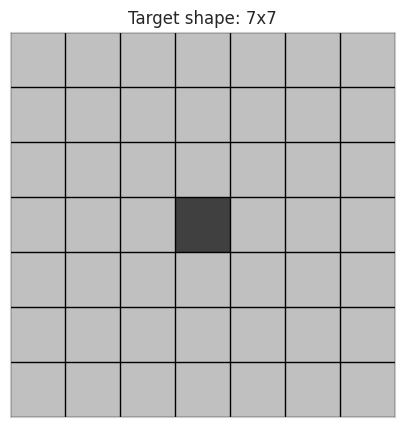

In [2]:
# Define the size of the structure to be built
target_size = 7

# Generate the target matrix using the DCES module
target_shape = DCES.generate_solid_square(target_size)

# Visualize the target shape and identify the seed position
DCES.plot_target_shape(target_shape)

It is also possible to load specific shapes from a text file using the `load_simulation_config` function, allowing for the construction of complex, user-defined structures.

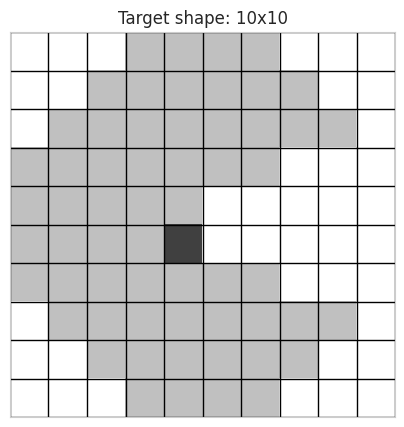

In [3]:
_, _, target_shape = DCES.load_simulation_config("data/target_shape_8.txt")

# Visualize the target shape and identify the seed position
DCES.plot_target_shape(target_shape)

## 3. Simulation Execution
The simulation is executed using the `run_simulation` function. This function initializes the `ConstructionModel`, sets up the grid with the specified number of robots and loose blocks, and runs the simulation loop.

Real-time visualization is provided to observe the swarm's behavior. The grid colors represent the state of the agents:
* **Silver:** structure blocks (part of the wall).
* **Dark gray:** the Seed block.
* **Blue:** loose blocks (available for pickup).
* **Red:** robots carrying a block.
* **Green:** empty robots searching for blocks.

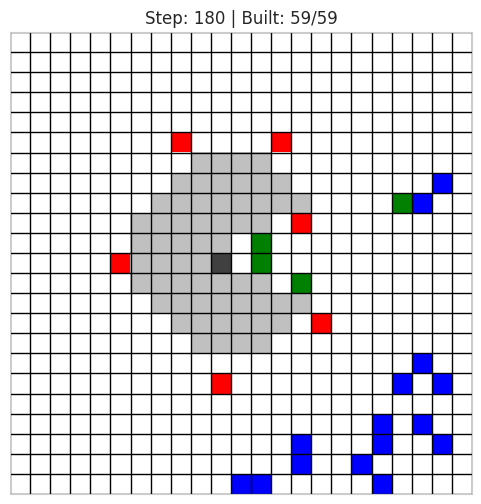

Construction Completed!


In [4]:
# Configure simulation parameters
n_robots = 10
max_steps = 2000
animation_delay = 0.001  # Seconds between frames

# Run the simulation with visualization
DCES.run_simulation(
    target_shape,
    N_robots=n_robots, 
    max_steps=max_steps, 
    delay=animation_delay,
)

## 4. Performance Analysis
A systematic multi-scale evaluation is executed using the `benchmark_multi_scale` function, varying both the structure size (widths 5, 7, 10) and swarm size (up to 100 robots). The simulation environment is constrained to a fixed $15 \times 15$ grid to rigorously observe the effects of high density and physical interference. Key performance metrics, including construction time and total distance traveled, are recorded across 10 independent trials for each configuration. This data is subsequently utilized to analyze the system's scalability and identify saturation points under strict spatial limits.

In [17]:
# --- Experiment 2: Multi-Scale Analysis (Research Component) ---
# This analysis varies both the structure scale and the swarm size
scales_to_test = [5, 7, 10]  # Width of the square
swarms_to_test = [1, 3, 5, 10, 15, 20, 30, 50, 75, 100]
trials = 10  

# Run the multi-scale benchmark
df_research = DCES.benchmark_multi_scale(
    structure_scales=scales_to_test, 
    swarm_sizes=swarms_to_test, 
    trials_per_config=trials,
    max_steps = 50000,
    width=15,
    height=15
)

Starting systematic experiment...
Scales to test: [5, 7, 10]
Swarm sizes to test: [1, 3, 5, 10, 15, 20, 30, 50, 75, 100]
  > Testing scale 5x5 with 1 robots (10 trials)...
  > Testing scale 5x5 with 3 robots (10 trials)...
  > Testing scale 5x5 with 5 robots (10 trials)...
  > Testing scale 5x5 with 10 robots (10 trials)...
  > Testing scale 5x5 with 15 robots (10 trials)...
  > Testing scale 5x5 with 20 robots (10 trials)...
  > Testing scale 5x5 with 30 robots (10 trials)...
  > Testing scale 5x5 with 50 robots (10 trials)...
  > Testing scale 5x5 with 75 robots (10 trials)...
  > Testing scale 5x5 with 100 robots (10 trials)...
  > Testing scale 7x7 with 1 robots (10 trials)...
  > Testing scale 7x7 with 3 robots (10 trials)...
  > Testing scale 7x7 with 5 robots (10 trials)...
  > Testing scale 7x7 with 10 robots (10 trials)...
  > Testing scale 7x7 with 15 robots (10 trials)...
  > Testing scale 7x7 with 20 robots (10 trials)...
  > Testing scale 7x7 with 30 robots (10 trials)...


In [18]:
# Display the first few rows of the collected metrics
print("Research Data Sample:")
display(df_research.head())

Research Data Sample:


,Scale,Swarm Size,Trial_ID,Time (Steps),Total Distance,Steps Per Block,Completion
0,5,1,0,572,572,23.833333,100.0
1,5,1,1,523,523,21.791667,100.0
2,5,1,2,624,624,26.000000,100.0
3,5,1,3,570,570,23.750000,100.0
4,5,1,4,527,527,21.958333,100.0


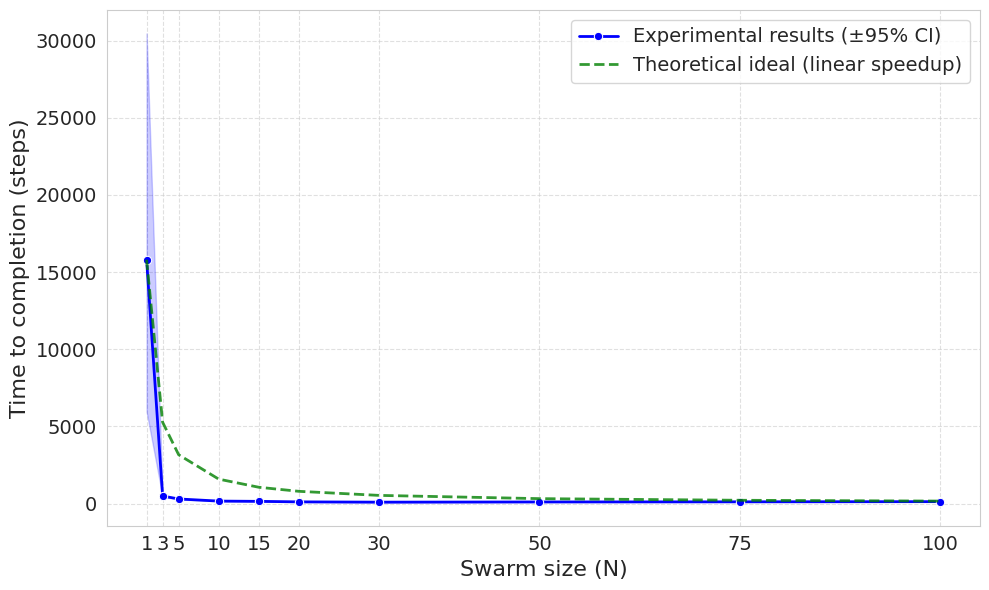

In [51]:
# --- SELECT THE SCALE TO SHOW ---
scale_to_plot = 7  # <--- Change this to 5, 7, or 10
# --------------------------------

# 1. Filter the data for that specific scale
subset = df_research[df_research["Scale"] == scale_to_plot]

plt.figure(figsize=(10, 6))

# Plot A: The Real Data (for the chosen scale)
sns.lineplot(
    data=subset, 
    x="Swarm Size", 
    y="Time (Steps)", 
    marker='o', 
    label=f"Experimental results (±95% CI)", 
    color='blue', 
    linewidth=2
)

# Plot B: The Ideal Theoretical Curve
# We calculate the baseline using only the data for this scale
if 1 in swarms_to_test:
    # Get the average time for 1 robot ON THIS SCALE
    baseline_time = subset[subset["Swarm Size"] == 1]["Time (Steps)"].mean()
    ideal_curve = [baseline_time / n for n in swarms_to_test]
    
    plt.plot(
        swarms_to_test, 
        ideal_curve, 
        '--', 
        label="Theoretical ideal (linear speedup)", 
        color='green', 
        alpha=0.8, 
        linewidth=2
    )

plt.xlabel("Swarm size (N)", fontsize=16)
plt.ylabel("Time to completion (steps)", fontsize=16)

# Use the specific swarm sizes tested for the X-axis ticks
plt.xticks(swarms_to_test, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend(fontsize=14)

plt.tight_layout()

# Save with a specific name so you don't overwrite others
plt.savefig(f'figures/scalability_scale_{scale_to_plot}.pdf', format='pdf', bbox_inches='tight')

plt.show()

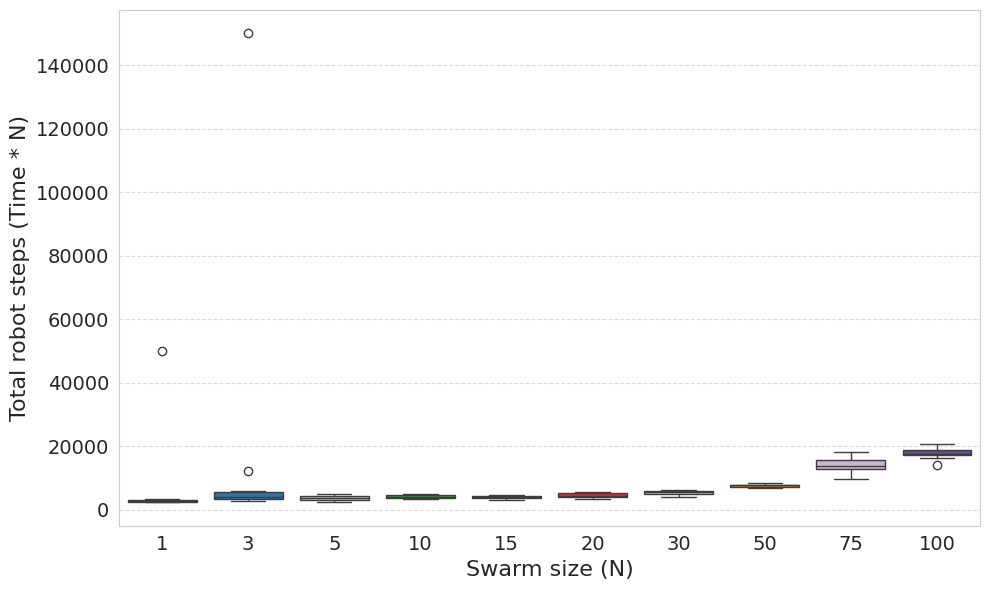

In [42]:
# --- SELECT THE SCALE TO SHOW ---
scale_to_plot = 10  # <--- Change this to 5, 7, or 10
# --------------------------------

plt.figure(figsize=(10, 6))

# 1. Filter the data for that specific scale
subset = df_research[df_research["Scale"] == scale_to_plot]

# 2. Plot
sns.boxplot(
    x="Swarm Size", 
    y="Total Distance", 
    hue="Swarm Size", 
    legend=False, 
    data=subset, 
    palette="Paired"
)

plt.xlabel("Swarm size (N)", fontsize=16)
plt.ylabel("Total robot steps (Time * N)", fontsize=16)

# Increase tick numbers size
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save with dynamic name
plt.savefig(f'figures/3_boxplot_distance_scale_{scale_to_plot}.pdf', format='pdf')

plt.show()

In [40]:
print("="*60)
print("STATISTICAL ANALYSIS (Friedman test)")
print("="*60)

# We pivot the data to get a matrix where rows=Trials, cols=Swarm_Sizes
# We analyze the largest scale as it's the most representative of complex tasks
pivot_data = subset.pivot(index="Trial_ID", columns="Swarm Size", values="Time (Steps)")

# Run Friedman Test (Non-parametric ANOVA)
stat, p_value = stats.friedmanchisquare(*[pivot_data[col] for col in pivot_data.columns])

print(f"Friedman test statistic: {stat:.4f}")
print(f"p-value: {p_value:.4e}")

if p_value < 0.05:
    print("\nResult: SIGNIFICANT DIFFERENCE FOUND.")
    print("The swarm size significantly affects construction time.")
    print("This confirms that the performance changes are not due to random noise.")
    
    # Optional: Nemenyi Post-Hoc Test (Requires 'scikit-posthocs' library)
    # If you can't install it, just report the Friedman result, which is often sufficient for a class project.
    try:
        import scikit_posthocs as sp
        print("\n--- Nemenyi post-hoc test (pairwise comparisons) ---")
        nemenyi = sp.posthoc_nemenyi_friedman(pivot_data)
        
        # Display p-values for difference between Size 1 vs others, etc.
        # Values < 0.05 mean those two sizes are significantly different.
        display(nemenyi)
    except ImportError:
        print("\n(Note: Install 'scikit-posthocs' to see exactly which pairs differ.)")
else:
    print("\nResult: NO SIGNIFICANT DIFFERENCE.")

STATISTICAL ANALYSIS (Friedman test)
Friedman test statistic: 82.9005
p-value: 4.2796e-14

Result: SIGNIFICANT DIFFERENCE FOUND.
The swarm size significantly affects construction time.
This confirms that the performance changes are not due to random noise.

--- Nemenyi post-hoc test (pairwise comparisons) ---


,1,3,5,10,15,20,30,50,75,100
1,1.000000e+00,9.998822e-01,0.926647,0.497614,0.060077,0.003606,0.000007,1.544011e-08,0.000048,0.000033
3,9.998822e-01,1.000000e+00,0.998421,0.871346,0.262239,0.030355,0.000142,5.789859e-07,0.000771,0.000556
5,9.266473e-01,9.984214e-01,1.000000,0.999261,0.796635,0.262239,0.004817,4.780185e-05,0.018568,0.014370
10,4.976144e-01,8.713463e-01,0.999261,1.000000,0.994324,0.752761,0.060077,1.455492e-03,0.160563,0.134052
15,6.007651e-02,2.622387e-01,0.796635,0.994324,1.000000,0.998421,0.497614,4.820751e-02,0.752761,0.705351
20,3.605592e-03,3.035464e-02,0.262239,0.752761,0.998421,1.000000,0.947071,3.481294e-01,0.994324,0.990232
30,6.985095e-06,1.416390e-04,0.004817,0.060077,0.497614,0.947071,1.000000,9.902323e-01,0.999998,1.000000
50,1.544011e-08,5.789859e-07,0.000048,0.001455,0.048208,0.348129,0.990232,1.000000e+00,0.926647,0.947071
75,4.780185e-05,7.707460e-04,0.018568,0.160563,0.752761,0.994324,0.999998,9.266473e-01,1.000000,1.000000
100,3.290465e-05,5.557938e-04,0.014370,0.134052,0.705351,0.990232,1.000000,9.470708e-01,1.000000,1.000000
